<center><font size = "10"> Multicompartmental Neuron Model: <center>
<center><font size = "8"> Cable Theory <center>
<center><font size = "8">Tutorial 02: Active Properties<center>

<font size="3"><font color="blue">In this tutorial you will se how the voltage signal propagates along simple mophologies with active membrane properties.
    
<font size='3'><font color='blue'>In order to understand what is going on along this tutorial, you should review the concepts of __cable theory__ in the lecture and/or in [here](https://en.wikipedia.org/wiki/Cable_theory) as well as the concept of __active electrical properties__ of a neuron in [here](http://www.scholarpedia.org/article/Neuron#:~:text=themes%20of%20concern.-,Passive%20electrical%20properties,cytoplasm%20and%20the%20extracellular%20milieu.)

# 1. Adding active properties to a soma

## 1.1 Biological modeling: mechanisms
<font size='3'>Mechanisms represent ion channels, buffers, synapses dynamics in NEURON. They are not point processes but "distributed mechanisms" and they are present on the entire surface of a section. Mechanisms parameters can change within compartments.

<font size='3'>NEURON has some built-in mechanisms, for example a passive leak current *pas* and sodium and potassium currents to generate action potentials *hh* (from the squid axon, measured by Hodgkin and Huxley!)

In [1]:
%matplotlib inline

# Import NEURON as a Python module, together with the hoc language and the gui
from neuron import h  # ,gui
import matplotlib.pyplot as plt

--No graphics will be displayed.


In [2]:
# Insert passive and active mechanisms
hhsoma = h.Section()
hhsoma.L = 20
hhsoma.diam = 20
hhsoma.nseg = 1

# Passive
hhsoma.insert("pas")
for seg in hhsoma:
    seg.pas.g = 0.003  # Conductance of the leak channels (in S/cm2)
    seg.pas.e = (
        -60
    )  # Leak reversal potential, it influences the steady state membrane potential

# Active
hhsoma.insert("hh")
for seg in hhsoma:
    seg.hh.gkbar = 0.008  # Maximal conductance of the potassium channels
    seg.hh.gnabar = 0.12  # Maximal conductance of the sodium channels

In [3]:
stim = h.IClamp(hhsoma(0.5))
stim.delay = 1
stim.dur = 1
stim.amp = 1

time = h.Vector()
voltage = h.Vector()
time.record(h._ref_t)
voltage.record(hhsoma(0.5)._ref_v)

Vector[1]

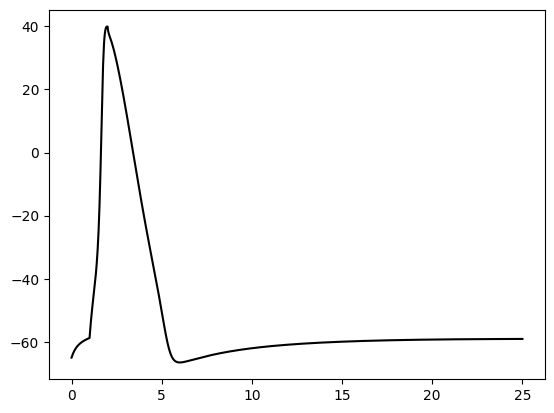

In [4]:
h.load_file("stdrun.hoc")

h.tstop = 25
h.finitialize(-65)

h.init()
h.run()

plt.plot(time, voltage, "k");

current_records# 2. Dendritic signal summation
<font size='3'>In this case we are going to use the cell that we have just created in tutorial 01.
    
<font color='red'><font size='5'>RESTART YOUR KERNEL

In [1]:
%matplotlib inline

from neuron import h
import matplotlib.pyplot as plt
import numpy as np
import math as m
import neurom as nm
from neurom import view
from hoc2swc import neuron2swc

--No graphics will be displayed.


In [2]:
# Global containers for objects
simulations_records = []  # stimulations
voltage_records = []  # voltage recordings
current_records = []  # current recordings


def reset():
    """Convenience functions for setting up stimulation, recording and simulation"""
    del simulations_records[:]
    del voltage_records[:]
    del current_records[:]


def iclamp(location, delay=100, amplitude=0.1, duration=500):
    """"Inject a current step with parameters at location"""
    stim = h.IClamp(location)  # Place a stimulation electrode at location
    stim.delay = delay  # stim delay (ms)
    stim.amp = amplitude  # stim amplitude (pA)
    stim.dur = duration  # stim ducurrent_recordsration (ms)
    simulations_records.append({"stim": stim, "loc": str(location)})


def record_voltage(location):
    """Setup recording of voltage at location"""
    vec = h.Vector()
    vec.record(location._ref_v)  # record voltage at location
    voltage_records.append({"vec": vec, "loc": str(location)})


def record_current(stimulation_dict):
    """Setup recording of stimulation current"""
    vec = h.Vector()
    vec.record(stimulation_dict["stim"]._ref_i)  # record stimulation current
    current_records.append({"vec": vec, "loc": stimulation_dict["loc"]})


def init_run(v_i, t_stop):
    """Initialize and run a simulation"""
    # Record time
    rec_t = h.Vector()
    rec_t.record(h._ref_t)
    # Record current for all stimuli
    for stimulation_dict in simulations_records:
        record_current(stimulation_dict)
    # Setup simulation and run
    h.load_file("stdrun.hoc")
    h.finitialize(v_i)  # initial voltage
    h.continuerun(t_stop)  # final time
    return rec_t


def tvi_plots(t, voltage_records=[], current_records=[], vmax=40, imax=0.5):
    """Plot current and voltage for all stims and recordings"""
    plt.figure()
    plt.title("currents")
    plt.ylim((-0.01, imax))
    plt.xlabel("t (ms)")
    plt.ylabel("I (pA)")
    for idict in current_records:
        plt.plot(t, idict["vec"], label=idict["loc"])
    plt.legend(loc=1)

    plt.figure()
    plt.title("voltages")
    plt.ylim((-71, vmax))
    plt.ylabel("V (mV)")
    plt.xlabel("t (ms)")
    for vdict in voltage_records:
        plt.plot(t, vdict["vec"], label=vdict["loc"])
    plt.legend(loc=1)


def plot_morphology(fname="cell_01"):
    fname = "{}.swc".format(fname)
    h.define_shape()
    h.topology()
    neuron2swc(fname, swap_yz=False)
    neuron1 = nm.load_morphology(fname)
    view.plot_morph(neuron1)

## 2.1 Add active properties at the soma


|-|       soma(0-1)
   `----|       dend(0-1)
         `|       branch_0(0-1)
         `|       branch_1(0-1)
         `|       branch_2(0-1)
         `|       branch_3(0-1)
 `----|       axon(0-1)

Wrote cell 0 to cell_03.swc


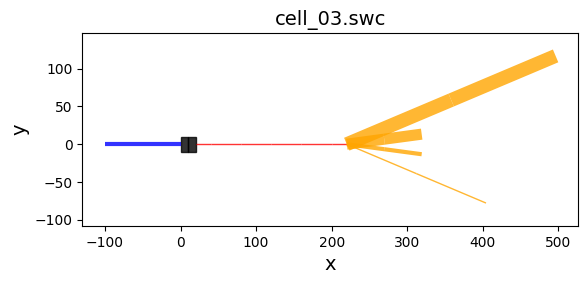

In [3]:
# SOMA
# Create soma
soma = h.Section(name="soma")
soma.L = 20  # length (µm)
soma.diam = 20  # diameter (µm)
soma.Ra = 123.0  # axial resistivity (Ω*cm)
soma.cm = 1  # capacitance (µF/cm^2)

# Insert passive properties
soma.insert("pas")
for seg in soma:
    seg.pas.g = 0.0003  # Conductance of the leak channels (in S/cm2)
    seg.pas.e = (
        -70
    )  # Leak reversal potential, it influences the steady state membrane potential

# Insert active properties
soma.insert("hh")
for seg in soma:
    seg.hh.gkbar = 0.1  # Maximal conductance of the potassium channels
    seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels

# AXON
axon = h.Section(name="axon")

# Axon section (blue in plot)
axon.diam = 3
axon.L = 100  # length (µm)
axon.nseg = 5  # diameter (µm)
axon.Ra = 123.0  # axial resistivity (Ω*cm)
axon.cm = 1  # capacitance (µF/cm^2)

# Topology
axon.connect(soma(0))

axon.insert("pas")
for seg in axon:
    seg.pas.g = 0.0003  # Conductance of the leak channels (in S/cm2)
    seg.pas.e = (
        -70
    )  # Leak reversal potential, it influences the steady state membrane potential

# DENDRITE
dend = h.Section(name="dend")

# Dendrite section (red in plot)
dend.L = 200  # length (µm)
dend.diam = 1  # diameter (µm)
dend.nseg = 5  # number of segments
dend.Ra = 123.0  # axial resistivity (Ω*cm)
dend.cm = 1  # capacitance (µF/cm^2)

# Topology
dend.connect(soma(1))

# Passive properties in dendrite and axon
dend.insert("pas")
for seg in dend:
    seg.pas.g = 0.0003  # Conductance of the leak channels (in S/cm2)
    seg.pas.e = (
        -70
    )  # Leak reversal potential, it influences the steady state membrane potential


# DENDRITIC BRANCHES
branch_0 = h.Section(name="branch_0")
branch_1 = h.Section(name="branch_1")
branch_2 = h.Section(name="branch_2")
branch_3 = h.Section(name="branch_3")

branchlst = [branch_0, branch_1, branch_2, branch_3]

# Branch geometry
# Long and thick
branch_0.L = 300
branch_0.diam = 10
# Short and thin
branch_1.L = 100
branch_1.diam = 8
# Short and thick
branch_2.L = 100
branch_2.diam = 3
# Long and thin
branch_3.L = 200
branch_3.diam = 1

# Connect them
branch_0.connect(dend(1))
branch_1.connect(dend(1))
branch_2.connect(dend(1))
branch_3.connect(dend(1))

# Passive properties in dendrite branches
for branch in branchlst:
    branch.Ra = 130.0  # axial resistivity (Ω*cm)
    branch.cm = 1  # capacitance (µF/cm^2)
    branch.insert("pas")
    for seg in branch:
        seg.pas.g = 0.0003  # Conductance of the leak channels (in S/cm2)
        seg.pas.e = (
            -70
        )  # Leak reversal potential, it influences the steady state membrane potential

plot_morphology("cell_03")

<font size="3">With coincident inputs to all dendritic branches, we're able to trigger an AP at the soma, which we can then observe in the dendrite trunk.

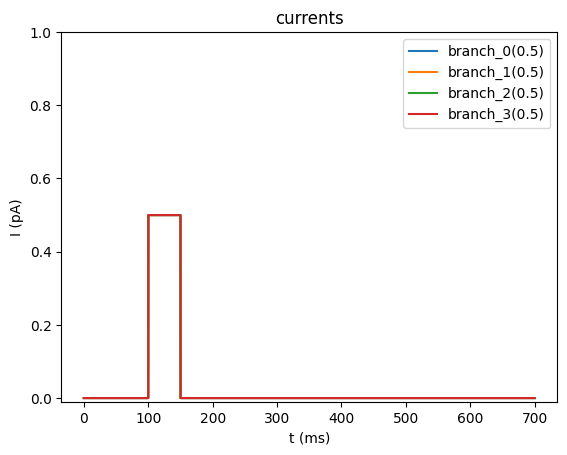

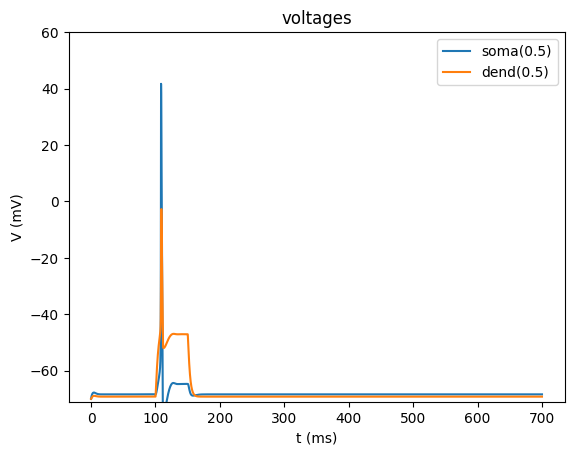

In [4]:
reset()

# Setup stimulations and recordings
for branch in branchlst:
    iclamp(branch(0.5), amplitude=0.5, delay=100, duration=50)
record_voltage(soma(0.5))
record_voltage(dend(0.5))

# Simulate and plot
v_init = -70
t_stop = 700
tvi_plots(init_run(v_init, t_stop), voltage_records, current_records, vmax=60, imax=1)

## 2.2 Add active properties at the dendrites

In [5]:
dend.insert("hh")
for seg in dend:
    seg.hh.gkbar = 0.1  # Maximal conductance of the potassium channels
    seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels

<font size="3">We observe that the dendritic response to the AP is increased due to the presence of active channels.

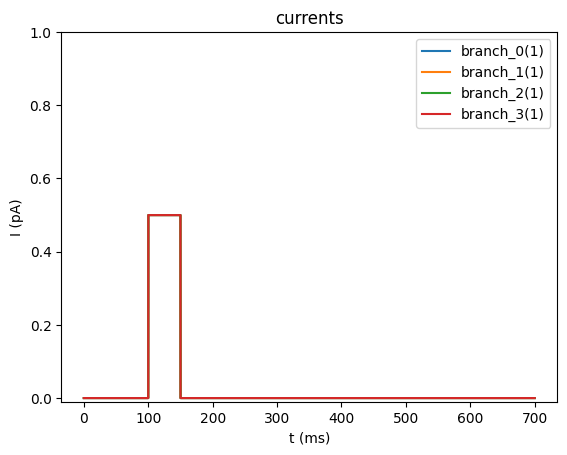

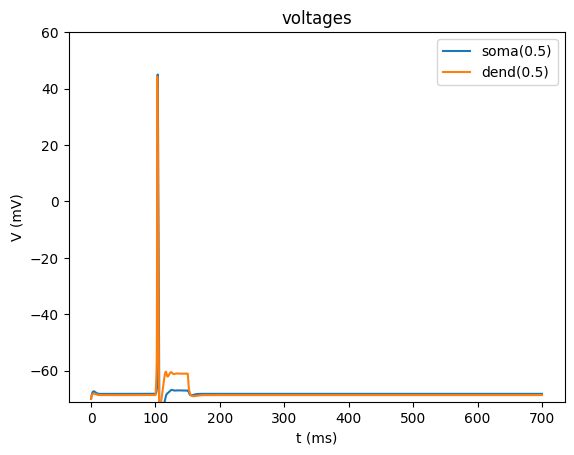

In [6]:
reset()

# Setup stimulations and recordings
for branch in branchlst:
    iclamp(branch(1), amplitude=0.5, delay=100, duration=50)
    # record_voltage(branch(0.5))
record_voltage(soma(0.5))
record_voltage(dend(0.5))

# Simulate and plot
v_init = -70
t_stop = 700
tvi_plots(init_run(v_init, t_stop), voltage_records, current_records, vmax=60, imax=1)